# 範例 : (Kaggle)房價預測

# [教學目標]
- 以下用房價預測資料, 展示特徵篩選的作法

# [範例重點]
- 觀察相關係數過濾法的寫作方式(In[2], Out[2], In[4], Out[4]), 以及對線性迴歸與梯度提升機有什麼影響 (In[5]~In[8], Out[5]~Out[8]) 
- 觀察L1 嵌入法的寫作方式(In[9]~In[11], Out[9]~Out[11]), 以及對線性迴歸與梯度提升機有什麼影響 (In[12], Out[12], In[13], Out[13]) 

In [1]:
# 做完特徵工程前的所有準備
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

data_path = 'Part02/'
df = pd.read_csv(data_path + 'house_train.csv.gz')

train_Y = np.log1p(df['SalePrice'])
df = df.drop(['Id'] , axis=1)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

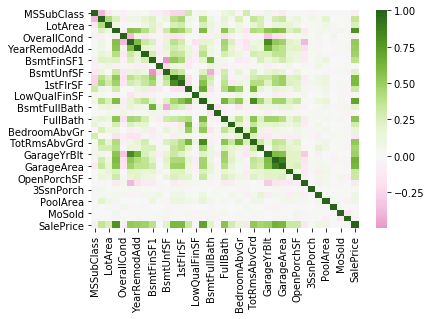

In [3]:
# 計算df整體相關係數, 並繪製成熱圖
corr = df.corr()
sns.heatmap(corr, center = 0, cmap = 'PiYG')
plt.show()

In [4]:
# 記得刪除 SalePrice
df = df.drop(['SalePrice'] , axis=1)

#只取 int64, float64 兩種數值型欄位, 存於 num_features 中
num_features = []
for dtype, feature in zip(df.dtypes, df.columns):
    if dtype == 'float64' or dtype == 'int64':
        num_features.append(feature)
        df[feature] = df[feature].astype('float64')
print(f'{len(num_features)} Numeric Features : {num_features}\n')

# 削減文字型欄位, 只剩數值型欄位
df = df[num_features]
df = df.fillna(-1)
MMEncoder = MinMaxScaler()
df.head()

36 Numeric Features : ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']



,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,...,548.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0,2.0,2008.0
1,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,...,460.0,298.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0
2,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,...,608.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,9.0,2008.0
3,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,...,642.0,0.0,35.0,272.0,0.0,0.0,0.0,0.0,2.0,2006.0
4,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,...,836.0,192.0,84.0,0.0,0.0,0.0,0.0,0.0,12.0,2008.0


In [5]:
# 篩選相關係數大於 0.1 或小於 -0.1 的特徵
high_list = list(corr[(corr['SalePrice']>0.1) | (corr['SalePrice']<-0.1)].index)
high_list.pop(-1)
print(high_list)

['LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch']


In [6]:
# 原始特徵 + 線性迴歸
train_X = MMEncoder.fit_transform(df)
estimator = LinearRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8466431428526562

In [7]:
# 高相關性特徵 + 線性迴歸
train_X = MMEncoder.fit_transform(df[high_list])
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8288821541594242

In [8]:
# 原始特徵 + 梯度提升樹
train_X = MMEncoder.fit_transform(df)
estimator = GradientBoostingRegressor()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8868779195598184

In [9]:
# 高相關性特徵 + 梯度提升樹
train_X = MMEncoder.fit_transform(df[high_list])
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.872259851032269

In [10]:
from sklearn.linear_model import Lasso
L1_Reg = Lasso(alpha=0.001)
train_X = MMEncoder.fit_transform(df)
L1_Reg.fit(train_X, train_Y)
L1_Reg.coef_

array([-0.12408194, -0.        ,  0.        ,  0.81411198,  0.2970946 ,
        0.33007182,  0.08851589,  0.        ,  0.04287006,  0.        ,
       -0.        ,  0.17513694,  0.11086056,  0.        , -0.        ,
        0.87326328,  0.2040765 ,  0.        ,  0.10285172,  0.03174629,
        0.        , -0.        ,  0.12246045,  0.17953898,  0.01851559,
        0.27672243,  0.03230955,  0.09061659,  0.        ,  0.        ,
        0.        ,  0.09550047, -0.        , -0.        ,  0.        ,
       -0.01874705])

In [11]:
L1_mask = list((L1_Reg.coef_>0) | (L1_Reg.coef_<0))
df.columns[L1_mask]

Index(['MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'BsmtFullBath',
       'FullBath', 'HalfBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'ScreenPorch', 'YrSold'],
      dtype='object')

In [12]:
# compress 可用於對數據進行篩選，當 selectors 的某元素為 true 時，則保留 data 對應位置的元素，否則去除
from itertools import compress
L1_list = list(compress(list(df), list(L1_mask)))
L1_list

['MSSubClass',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'BsmtFinSF1',
 'TotalBsmtSF',
 '1stFlrSF',
 'GrLivArea',
 'BsmtFullBath',
 'FullBath',
 'HalfBath',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'ScreenPorch',
 'YrSold']

In [13]:
# L1_Embedding 特徵 + 線性迴歸
train_X = MMEncoder.fit_transform(df[L1_list])
estimator = LinearRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8475901403725674

In [14]:
# L1_Embedding 特徵 + 梯度提升樹
train_X = MMEncoder.fit_transform(df[L1_list])
estimator = GradientBoostingRegressor()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8850286666984388

# 作業 : (Kaggle)鐵達尼生存預測
https://www.kaggle.com/c/titanic

# [作業目標]
- 試著調整特徵篩選的門檻值, 觀察會有什麼影響效果

# [作業重點]
- 調整相關係數過濾法的篩選門檻, 看看篩選結果的影響 (In[5]~In[8], Out[5]~Out[8])
- 調整L1 嵌入法篩選門檻, 看看篩選結果的影響 (In[9]~In[11], Out[9]~Out[11])

In [15]:
# 做完特徵工程前的所有準備 (與前範例相同)
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

data_path = 'Part02/'
df = pd.read_csv(data_path + 'titanic_train.csv')

train_Y = df['Survived']
df = df.drop(['PassengerId'] , axis=1)
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


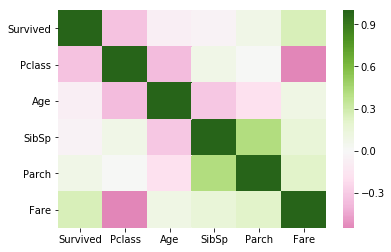

In [16]:
# 計算df整體相關係數, 並繪製成熱圖
import seaborn as sns
import matplotlib.pyplot as plt
corr = df.corr()
sns.heatmap(corr, center = 0, cmap = 'PiYG')
plt.show()

In [17]:
# 記得刪除 Survived
df = df.drop(['Survived'] , axis=1)

#只取 int64, float64 兩種數值型欄位, 存於 num_features 中
num_features = []
for dtype, feature in zip(df.dtypes, df.columns):
    if dtype == 'float64' or dtype == 'int64':
        num_features.append(feature)
        df[feature] = df[feature].astype('float64')
print(f'{len(num_features)} Numeric Features : {num_features}\n')

# 削減文字型欄位, 只剩數值型欄位
df = df[num_features]
df = df.fillna(-1)
MMEncoder = MinMaxScaler()
df.head()

5 Numeric Features : ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']



,Pclass,Age,SibSp,Parch,Fare
0,3.0,22.0,1.0,0.0,7.2500
1,1.0,38.0,1.0,0.0,71.2833
2,3.0,26.0,0.0,0.0,7.9250
3,1.0,35.0,1.0,0.0,53.1000
4,3.0,35.0,0.0,0.0,8.0500


# 作業1
* 鐵達尼生存率預測中，試著變更兩種以上的相關係數門檻值，觀察預測能力是否提升?
  - 以0.05為門檻時，預測能力提升

In [18]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# 原始特徵 + 邏輯斯迴歸
train_X = MMEncoder.fit_transform(df)
estimator = LogisticRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.7038635542329971

In [19]:
# 篩選相關係數1
high_list = list(corr[(corr['Survived']>0.1) | (corr['Survived']<-0.1)].index)
high_list.pop(0)
print(high_list)

['Pclass', 'Fare']


In [20]:
# 特徵1 + 邏輯斯迴歸
train_X = MMEncoder.fit_transform(df[high_list])
estimator = LogisticRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.6791567235397566

In [21]:
# 特徵1 + 梯度提升樹
train_X = MMEncoder.fit_transform(df[high_list])
estimator = GradientBoostingRegressor()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.14300997621701325

In [22]:
# 篩選相關係數2
high_list = list(corr[(corr['Survived']>0.05) | (corr['Survived']<-0.05)].index)
high_list.pop(0)
print(high_list)

['Pclass', 'Age', 'Parch', 'Fare']


In [23]:
# 特徵2 + 邏輯斯迴歸
train_X = MMEncoder.fit_transform(df[high_list])
estimator = LogisticRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.7049872206659582

In [24]:
# 特徵2 + 梯度提升樹
train_X = MMEncoder.fit_transform(df[high_list])
estimator = GradientBoostingRegressor()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.17053778078024348

# 作業2
* 續上題，使用 L1 Embedding 做特徵選擇(自訂門檻)，觀察預測能力是否提升?
  - 所有特徵皆保留，和原始模型同

In [25]:
from sklearn.linear_model import Lasso
L1_Reg = Lasso(alpha=0.001)
train_X = MMEncoder.fit_transform(df)
L1_Reg.fit(train_X, train_Y)
L1_Reg.coef_

array([-0.39684291, -0.25338753, -0.19144856,  0.28161304,  0.28188094])

In [26]:
from itertools import compress
L1_mask = list((L1_Reg.coef_>0) | (L1_Reg.coef_<0))
L1_list = list(compress(list(df), list(L1_mask)))
L1_list

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [27]:
# L1_Embedding 特徵 + 線性迴歸
train_X = MMEncoder.fit_transform(df[L1_list])
estimator = LogisticRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.7038635542329971

In [28]:
# L1_Embedding 特徵 + 梯度提升樹
train_X = MMEncoder.fit_transform(df[L1_list])
estimator = GradientBoostingRegressor()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.18278842450337074